 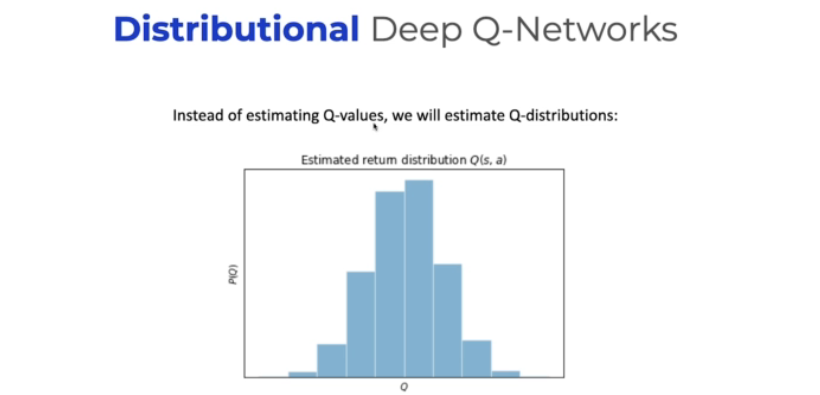

# Distributional Deep Q-Networks

__Distributional Deep Q-Networks__ (C51) is an extension of the traditional Deep Q-Networks (DQN) framework that __aims to address the limitations of representing Q-values as single expected values__. While conventional DQNs output a scalar value representing the expected return, __C51 models the entire distribution of possible returns for each state-action pair__. __This allows it to capture uncertainty and better handle scenarios where multiple outcomes are possible.__


__Keys components:__

1. __Probability Distribution:__
  - Instead of estimating a single expected return for each state-action pair, C51 represents the Q-value as a probability distribution over possible returns.
  - The distribution is discretized into a fixed number of support points, and the network outputs probabilities for each of these points.

2. __Categorical Distribution:__
  - C51 uses a categorical distribution to represent the probability mass function over the support points.
  - The support points are essentially the possible values that the return can take, and the network outputs probabilities for each support point.
    - __Support Points:__
      - The support points are discrete values that span the range of possible returns for a particular state-action pair.
      - They are essentially representative points on the distribution of returns.
      - The number of support points is predefined and fixed.

3. __Distributional Bellman Equation:__
  - The learning process is guided by the distributional Bellman equation, which updates the distribution of returns for each state-action pair.
  - The update is based on the observed rewards and the projected distribution of returns from the next state.

4. __Categorical Cross-Entropy Loss:__
  - To train the network, a categorical cross-entropy loss is used. It measures the divergence between the predicted distribution and the target distribution.
  - The target distribution is constructed using the observed rewards and the distribution of returns from the next state.

5. __Projecting the Distribution:__
  - When updating the distribution, it involves projecting the distribution of returns from the next state onto the support points.
  - This projection is a form of distributional temporal difference learning, which allows the network to capture the full distributional information.

6. __Stochasticity and Exploration:__
  - The distributional nature of C51 introduces a form of stochasticity in the learning process.
  - This stochasticity can enhance exploration as the network learns not only the expected values but also the uncertainty associated with different actions.


> _In summary, Distributional Deep Q-Networks provide a probabilistic perspective on Q-value estimation, enabling the model to capture and learn the entire distribution of returns. This approach has been shown to improve the stability and performance of deep reinforcement learning algorithms in various environments._

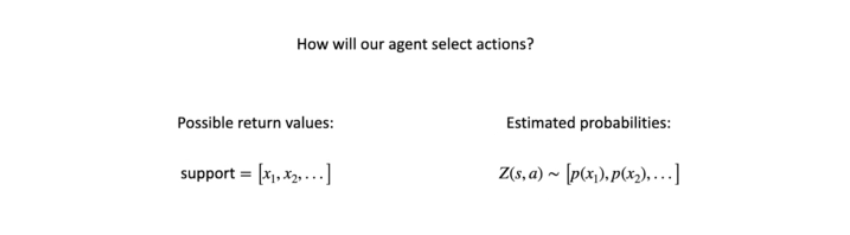

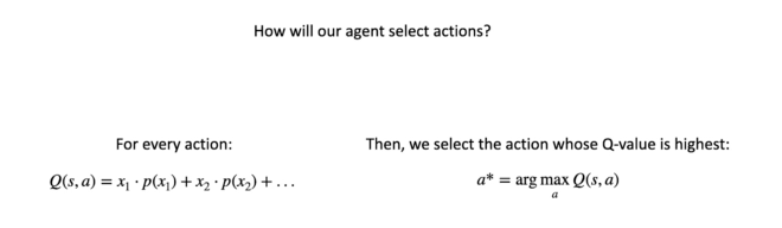

In [ ]:
!apt-get install -y xvfb

!pip install \
  gym[atari,accept-rom-license]==0.23.1 \
  pytorch-lightning==1.6.0 \
  stable-baselines3 \
  pyvirtualdisplay

#### Setup virtual display

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [ ]:
import copy
import torch
import random
import gym
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import TransformObservation, NormalizeObservation, \
  NormalizeReward, RecordVideo, RecordEpisodeStatistics, AtariPreprocessing


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [ ]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the Deep Q-Network

In [ ]:
import math
from torch.nn.init import kaiming_uniform_, zeros_

class NoisyLinear(nn.Module):
  """
  Noisy linear layer, for regularization and balance between exploration
  and exploitation.
  """
  def __init__(self, in_features, out_features, sigma):
    super(NoisyLinear, self).__init__()
    self.w_mu = nn.Parameter(torch.empty((out_features, in_features)))
    self.w_sigma = nn.Parameter(torch.empty((out_features, in_features)))
    self.b_mu = nn.Parameter(torch.empty((out_features)))
    self.b_sigma = nn.Parameter(torch.empty((out_features)))

    kaiming_uniform_(self.w_mu, a=math.sqrt(5))
    kaiming_uniform_(self.w_sigma, a=math.sqrt(5))
    zeros_(self.b_mu)
    zeros_(self.b_sigma)

  def forward(self, x, sigma=0.5):
    if self.training:
      w_noise = torch.normal(0, sigma, size=self.w_mu.size()).to(device)
      b_noise = torch.normal(0, sigma, size=self.b_mu.size()).to(device)
      return F.linear(x, self.w_mu + self.w_sigma * w_noise, self.b_mu + self.b_sigma * b_noise)
    else:
      return F.linear(x, self.W_mu, self.b_mu)

In [ ]:
class DQN(nn.Module):
  """
  Distributional Deep-Q-Network that combine Noisy DQN

  Parameters
  -----------
  - `hidden_size`: number of hidden layers
  - `obs_shape`: size of the shape (Input)
  - `n_actions: size of the actions (Output)
  - `atoms`: Number of discrete support points used to represent the distribution of returns for each state-action pair.
  - `sigma`: Measure of the standard deviation of the noise to explore the environment.
  """

  def __init__(self, hidden_size, obs_shape, n_actions, atoms=51, sigma=0.5):
    super().__init__()
    self.atoms = atoms
    self.n_actions = n_actions

    # Convolutional layers to process input observations
    self.conv = nn.Sequential(
      # Input: state
      nn.Conv2d(obs_shape[0], 64, kernel_size=3),
      nn.MaxPool2d(kernel_size=4),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3),
      nn.MaxPool2d(kernel_size=4),
      nn.ReLU()
    ) # Output: features extractions.

    # Take the Output size of the Conv network
    conv_out_size = self._get_conv_out(obs_shape)

    # ..after `conv_out_size` we have the size of flatten vector of features..

    # Head network with NoisyLinear layer for feature extraction
    self.head = nn.Sequential(
      NoisyLinear(conv_out_size, hidden_size, sigma=sigma),
      nn.ReLU(),
    )

    # Separate streams for the advantage and value components
    # - Input: extracted vector features
    # - Output: number of action * number of discrete support points
    self.fc_adv = NoisyLinear(hidden_size, self.n_actions * self.atoms, sigma=sigma)
    # - Input: extracted vector features
    # - Output: number of discrete support points
    self.fc_value = NoisyLinear(hidden_size, self.atoms, sigma=sigma)

  # Return the size of output of the Conv network.
  def _get_conv_out(self, shape):
    conv_out = self.conv(torch.zeros(1, *shape))
    return int(np.prod(conv_out.size()))

  def forward(self, x):

    # 1. Forward pass through convolutional and Head layers
    x = self.conv(x.float()).view(x.size()[0], -1) # pass to Conv, then flat to vector
    x = self.head(x) # then pass to the Head net.

    # 2. Separate streams for the advantage and value components
    adv = self.fc_adv(x).view(-1, self.n_actions, self.atoms)  # (B, A, N) -> batch size, number of actions that the agent can take, number of atoms
    value = self.fc_value(x).view(-1, 1, self.atoms)  # (B, 1, N) -> batch size, V(s), number of atoms

    # 3. Combine streams to form the final distribution
    q_logits = value + adv - adv.mean(dim=1, keepdim=True)  # (B, A, N)

    # 4. Apply softmax activation to obtain probabilities
    q_probs = F.softmax(q_logits, dim=-1)  # (B, A, N)

    # 5. Return the Q(s,a) probabilities
    return q_probs

#### Create the policy

In [ ]:
def greedy(state, net, support):
  """
  Greedy policy that selects the action yielding the maximum Q-value.

  Parameters
  -----------
  - `state`: Current state of the environment.
  - `net`: Neural network model (DQN) used to predict Q-value distributions.
  - `support`: Discrete support points used in the distributional Q-function.

  Returns
  -----------
  - `action`: Selected action based on the greedy policy.
  """

  # 1. Convert the state to a PyTorch tensor and move it to the appropriate device
  state = torch.tensor([state]).to(device)

  # 2. Predict the Q-value probability distribution for the given state.
  # - The number of atoms is an array of the same size as the support
  #   that we use to describe the probability of each of the items in the
  #   support of being the value of an action.
  q_value_probs = net(state)  # (1, A, N)

  # 3. Calculate the Q-values by summing the element-wise product of support points and probabilities
  # support (value) * atom (probability), then sum the x-axis.
  # by sum them together, we get the expected value of each action
  q_values = (support * q_value_probs).sum(dim=-1)  # (1, A) -> signal value of each of the actions.

  # 4. Select the action corresponding to the maximum Q-value
  action = torch.argmax(q_values, dim=-1)  # (1, 1)

  # 5. Convert the selected action to a Python integer
  action = int(action.item())  # ()

  return action

#### Create the replay buffer

In [ ]:
class ReplayBuffer:
  """
  Replay buffer memory with PER
  """

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)
    self.priorities = deque(maxlen=capacity)
    self.capacity = capacity
    self.alpha = 0.0  # anneal.
    self.beta = 1.0  # anneal.
    self.max_priority = 0.0

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)
    self.priorities.append(self.max_priority)

  def update(self, index, priority):
    if priority > self.max_priority:
      self.max_priority = priority
    self.priorities[index] = priority

  def sample(self, batch_size):
    prios = np.array(self.priorities, dtype=np.float64) + 1e-4 # Stability constant.
    prios = prios ** self.alpha
    probs = prios / prios.sum()

    weights = (self.__len__() * probs) ** -self.beta
    weights = weights / weights.max()

    idx = random.choices(range(self.__len__()), weights=probs, k=batch_size)
    sample = [(i, weights[i], *self.buffer[i]) for i in idx]
    return sample

In [ ]:
class RLDataset(IterableDataset):
  """
  Itetable datasey
  """

  def __init__(self, buffer, sample_size=400):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

#### Create the environment

In [ ]:
env = gym.make('QbertNoFrameskip-v4')

In [ ]:
env.observation_space, env.action_space

In [ ]:
frames = []
i = 60
skip = 8
obs = env.reset()
done = False

while not done:
  frames.append(obs)
  obs, _, done, _ = env.step(env.action_space.sample())

frames = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(frames)

In [ ]:
env = AtariPreprocessing(env, frame_skip=8, screen_size=42)

In [ ]:
frames = []
i = 40
skip = 1
obs = env.reset()
done = False

while not done:
  frames.append(obs)
  obs, _, done, _ = env.step(env.action_space.sample())

img = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(img, cmap='gray')

In [ ]:
env = NormalizeObservation(env)

In [ ]:
frames = []
i = 100
skip = 1

for i in range(20):
  obs = env.reset()
  done = False
  while not done:
    frames.append(obs)
    obs, _, done, _ = env.step(env.action_space.sample())

img = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(img.squeeze(), cmap='gray')

In [ ]:
def create_environment(name):
  env = gym.make(name)
  env = RecordVideo(env, 'videos', episode_trigger=lambda e: e % 100 == 0)
  env = AtariPreprocessing(env, frame_skip=8, screen_size=42)
  env = RecordEpisodeStatistics(env)
  env = TransformObservation(env, lambda x: x[np.newaxis,:,:])
  env.observation_space = gym.spaces.Box(low=0, high=1, shape=(1, 42, 42), dtype=np.float32)
  env = NormalizeObservation(env)
  env = NormalizeReward(env)
  return env

In [ ]:
env = create_environment('QbertNoFrameskip-v4')
frames = []
for episode in range(10):
  done = False
  obs = env.reset()
  while not done:
    frames.append(obs)
    action = env.action_space.sample()
    obs, _, done, _ = env.step(action)

In [ ]:
display_video(episode=0)

#### Create the Deep Q-Learning algorithm

In [ ]:
class DeepQLearning(LightningModule):
  """
  Implementation of:
  - N-steps Deep Q Learning
  - with Prioritized Experience Replay
  - Distributional Deep Q-Networks
  - Dueling DQN
  - Double DQN

  Parameters
  -----------
  - `env_name`: Name of the environment.
  - `policy`: Policy function (default: greedy).
  - `capacity`: Maximum capacity of the replay buffer.
  - `batch_size`: Batch size for training.
  - `lr`: Learning rate for the Q-network.
  - `hidden_size`: Number of hidden layers in the Q-network.
  - `gamma`: Discount factor for future rewards.
  - `loss_fn`: Loss function for the Q-network.
  - `optim`: Optimizer for training the Q-network.
  - `samples_per_epoch`: Number of samples to collect in the experience buffer before training.
  - `sync_rate`: Frequency at which to synchronize the target Q-network with the online Q-network.
  - `sigma`: Standard deviation of the noise for Noisy DQN.
  - `a_start`: Initial value of alpha for prioritized experience replay.
  - `a_end`: Final value of alpha for prioritized experience replay.
  - `a_last_episode`: Episode at which alpha reaches its final value.
  - `b_start`: Initial value of beta for prioritized experience replay.
  - `b_end`: Final value of beta for prioritized experience replay.
  - `b_last_episode`: Episode at which beta reaches its final value.
  - `n_steps`: Number of steps for N-step Deep Q Learning.
  - `v_min`: Minimum value of the support for Distributional DQN.
  - `v_max`: Maximum value of the support for Distributional DQN.
  - `atoms`: Number of discrete support points used to represent the distribution of returns for each state-action pair.
  """
  # Initialize.
  def __init__(self, env_name, policy=greedy, capacity=100_000,
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99,
               loss_fn=F.smooth_l1_loss, optim=AdamW, samples_per_epoch=10_000,
               sync_rate=10, sigma=0.5, a_start=0.5, a_end=0.0, a_last_episode=100,
               b_start=0.4, b_end=1.0, b_last_episode=100, n_steps=3,
               v_min=-10.0, v_max=10.0, atoms=51):

    super().__init__()

    # 1. Create the support vector
    # - a linear space with range of [v_min -> v_max] with `atoms` elements.
    self.support = torch.linspace(v_min, v_max, atoms, device=device)  # (N)

    # 2. calculates the difference between adjacent support points,
    #    which is useful for later calculations (in the training step function).
    self.delta = (v_max - v_min) / (atoms - 1)

    # 3. Create the environment
    self.env = create_environment(env_name)

    # 4. Define Input & Output shape
    obs_size = self.env.observation_space.shape # Input shape: state
    n_actions = self.env.action_space.n # Output shape: action size

    # 5. Initial the DQN
    self.q_net = DQN(hidden_size, obs_size, n_actions, atoms=atoms, sigma=sigma)

    # 6. Initial the Target-DQN
    self.target_q_net = copy.deepcopy(self.q_net)

    # 7. Set the policy (Greedy)
    self.policy = policy

    # 8. Initialize replay buffer
    self.buffer = ReplayBuffer(capacity=capacity)

    # 9. save the hyperparameters
    self.save_hyperparameters()

    # 10. Initial experiences and pass that into the Buffer memory.
    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episode()

  @torch.no_grad()
  def play_episode(self, policy=None):
    """
    Play epicode function.

    its suitable for N-step & distributional DQN.
    """

    # 1. Get initial state
    state = self.env.reset()
    # 2. set stop condition
    done = False
    # 3. Initialize list for store the transitions
    transitions = []

    # 4. Play epicode
    while not done:
      if policy: # if there is policy, get action based on the policy
        action = policy(state, self.q_net, self.support) # get the best action
      else: # random policy
        action = self.env.action_space.sample()

      # Perform the action, get the transition and store it.
      next_state, reward, done, info = self.env.step(action)
      exp = (state, action, reward, done, next_state)
      transitions.append(exp)
      state = next_state

    # ..so far we have list of transitions..

    # 5. Compute the N-step return
    for i, (s, a, r, d, ns) in enumerate(transitions):
      # Extract N-step transition
      batch = transitions[i:i+self.hparams.n_steps]
      # Compute the N-step return
      ret = sum([t[2] * self.hparams.gamma**j for j, t in enumerate(batch)])
      # Extract the last `is_done` and the last `state` from that N-step batch
      _, _, _, ld, ls = batch[-1]
      # Add the transition to the Memory.
      self.buffer.append((s, a, ret, ld, ls))

  # Forward.
  def forward(self, x):
    """
    Return the Q-values probabilities distribution.
    """
    return self.q_net(x)

  # Configure optimizers.
  def configure_optimizers(self):
    """
    Configure optimzier for updating the DQN weigths
    """
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), lr=self.hparams.lr)
    return [q_net_optimizer]

  # Create dataloader.
  def train_dataloader(self):
    """
    Return data loader object for training the agent.
    """
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader

  # Training step.
  def training_step(self, batch, batch_idx):
    """
    Execute a training step of rainbow DQN.
    """
    # 1. Extract data from the batch.
    indices, weights, states, actions, returns, dones, next_states = batch
    # make sure that the data in the right shape:
    # [[r], [r], ...]
    # [[d], [d], ...]
    returns = returns.unsqueeze(1)
    dones = dones.unsqueeze(1)
    # extract the size of the batch
    batch_size = len(indices)

    # 2. Compute Q-value probabilities for the current state(s) by DQM
    # Its look like:
    # [
    #   [ # Batch 1
    #     [p_11, p_12, p_13, ...],  # Action 1
    #     [p_21, p_22, p_23, ...],  # Action 2
    #     [p_31, p_32, p_33, ...]   # Action 3
    #   ],
    #   [  # Batch N... ]
    # ]
    q_value_probs = self.q_net(states)  # (B, A, N) -> (barch size, actions, atoms)

    # 3. Extract Q-value probabilities corresponding to the taken actions
    # - we are going to take every single element of this `atoms` items
    #   that are related to the specific action that we took in that state.
    # Its look like this:
    # [
    #  [p_11, p_12, p_13, p_14],  # Batch 1
    #  [p_21, p_22, p_23, p_24]   # Batch 2
    # ]
    action_value_probs = q_value_probs[range(batch_size), actions, :]  # (B, N) -> batch, atoms

    # Calculate the log probability of each action (for compute the loss later):
    # Its look like:
    # [
    #  [log(p_11), log(p_12), log(p_13), log(p_14)],  # Batch 1
    #  [log(p_21), log(p_22), log(p_23), log(p_24)]   # Batch 2
    # ]
    log_action_value_probs = torch.log(action_value_probs + 1e-6)  # (B, N)

    # 4. Compute Target-Q-value probabilities for the next state by Target-DQN
    with torch.no_grad():
      # Get Q-value probabilities for the next states.
      next_q_value_probs = self.q_net(next_states)  # (B, A, N)
      # Compute the expected Q-values
      # - probably of each Q-value * its support, then sum it -> this is the expected value
      next_q_values = (next_q_value_probs * self.support).sum(dim=-1)  # (B, A)
      # Take the BEST actions that yield the best Q-value
      next_actions = next_q_values.argmax(dim=-1)  # (B,) -> One best action that assosiated to each one of the states

      # ..now we have the actions of the next states...

      # Use the Target-Q-network to compute the target!
      # - compute the next Q-values probabilities
      next_q_value_probs = self.target_q_net(next_states)  # (B, A, N)
      # - extract the Q-values of the next state that correspond to the BEST actions
      next_action_value_probs = next_q_value_probs[range(batch_size), next_actions, :]  # (B, N)

    # 5. Compute the target distribution support

    # 5.1 Initialize a tensor to store the target distribution probabilities for each state-action pair
    m = torch.zeros(batch_size * self.hparams.atoms, device=device, dtype=torch.float64)  # (B * N)

    # 5.2 Compute the target distribution for each state-action pair
    Tz = returns + ~dones * self.hparams.gamma**self.hparams.n_steps * self.support.unsqueeze(0)  # (B, N)

    # 5.3 Clip the target distribution values to the specified range
    Tz.clamp_(min=self.hparams.v_min, max=self.hparams.v_max)  # (B, N)

    # 5.4 Calculate the normalized indices for the target distribution values
    b = (Tz - self.hparams.v_min) / self.delta  # (B, N)
    l, u = b.floor().long(), b.ceil().long()  # (B, N)

    # 5.5 Compute the indices for the lower and upper bounds of the target distribution
    offset = torch.arange(batch_size, device=device).view(-1, 1) * self.hparams.atoms  # (B, 1)
    l_idx = (l + offset).flatten()  # (B * N)
    u_idx = (u + offset).flatten()  # (B * N)

    # 5.6 Calculate the probabilities associated with the upper and lower bounds
    upper_probs = (next_action_value_probs * (u - b)).flatten()  # (B * N)
    lower_probs = (next_action_value_probs * (b - l)).flatten()  # (B * N)

    # 5.7 Update the target distribution tensor using the calculated probabilities
    m.index_add_(dim=0, index=l_idx, source=upper_probs)
    m.index_add_(dim=0, index=u_idx, source=lower_probs)

    # 5.8 Reshape the target distribution tensor to its original shape
    m = m.reshape(batch_size, self.hparams.atoms)  # (B, N)

    # 6. Compute cross-entropy loss between predicted and target distributions
    cross_entropies = - (m * log_action_value_probs).sum(dim=-1)  # (B,)

    # 7. Update priorities in the replay buffer
    for idx, e in zip(indices, cross_entropies):
      self.buffer.update(idx, e.detach().item())

    # 8. Compute the weighted mean of the loss
    loss = (weights * cross_entropies).mean()

    # 9. Log the loss for monitoring and return the loss
    self.log('episode/Q-Error', loss)
    return loss

  # Training epoch end.
  def training_epoch_end(self, training_step_outputs):
    """
    Callback function where the epoch training over
    """
    # Calculate alpha & beta
    alpha = max(
        self.hparams.a_end,
        self.hparams.a_start - self.current_epoch / self.hparams.a_last_episode
    )
    beta = min(
        self.hparams.b_end,
        self.hparams.b_start + self.current_epoch / self.hparams.b_last_episode
    )

    # Update alpha & beta
    self.buffer.alpha = alpha
    self.buffer.beta = beta

    # Play one epicode for create more experience and pass it to the memory.
    # wach epoch we want to updata and add more newer and relevant
    # experiences to the memory.
    self.play_episode(policy=self.policy)
    self.log('episode/Return', self.env.return_queue[-1])

    # Update the Target-DQN weigths each `sync_rate` times.
    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Train the policy

In [ ]:
algo = DeepQLearning(
  'QbertNoFrameskip-v4',
  lr=0.0001,
  sigma=0.5,
  hidden_size=512,
  a_last_episode=2_000,
  b_last_episode=2_000,
  n_steps=8,
)

trainer = Trainer(
  gpus=num_gpus,
  max_epochs=2_400,
  log_every_n_steps=1
)

trainer.fit(algo)

#### Check the resulting policy

In [ ]:
display_video(episode=2000)